# Classification Model on Vaccination Dataset
***

### 0.1 Importing Packages

In [31]:
#general purpose packages
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 0.2 Reading data

In [2]:
data = pd.read_excel("Biostatem_OMS.xls")

## 1. Data Cleaning
### 1.1. Overview

In [3]:
data.sample(10)

,ZON,NUMIND,SEXE,DTP1,RG,BCG,AGMER,AGEND,END,MAT,DISP,MALNU1,DEATH,GRDTP1,GRBCG,GRRG,FRESH,DIAR,FEVE,COU
129,0,8388,1,23.0,23.0,2.0,18,101,3,NaN,0,NaN,NaN,0,1,0,1,0,0,0
365,0,9190,0,NaN,NaN,NaN,27,31,1,NaN,0,2.0,2.0,0,0,0,0,0,0,0
404,0,9359,1,6.0,NaN,6.0,25,97,3,NaN,0,1.0,NaN,0,0,0,0,0,0,0
738,1,19681,1,10.0,10.0,NaN,25,88,2,NaN,0,1.0,NaN,0,0,1,1,0,0,0
824,1,19941,1,43.0,NaN,5.0,34,120,3,NaN,1,2.0,NaN,0,1,0,0,0,0,0
331,0,9065,1,4.0,43.0,4.0,41,94,3,NaN,0,1.0,NaN,1,1,0,0,0,0,0
482,0,9582,1,2.0,22.0,2.0,22,86,3,NaN,0,2.0,NaN,1,1,0,1,0,0,0
791,1,19809,0,8.0,20.0,6.0,36,120,3,NaN,1,2.0,NaN,0,0,0,0,0,0,0
445,0,9505,1,11.0,11.0,11.0,31,96,3,NaN,0,1.0,NaN,0,0,1,0,0,0,0
720,1,19628,0,14.0,10.0,13.0,29,120,3,NaN,0,0.0,NaN,0,0,1,1,0,0,0


### 1.2. Renaming features

In [4]:
data.rename(columns={'ZON':'region', 'NUMIND':'id', 'SEXE':'sex', 'DTP1':'dtp_age', 'RG':'rg_age', 'BCG':'bcg_age',                          'AGMER':'mother_age', 'AGEND':'end_age', 'END':'end_status', 'MAT':'delivery', 'DISP':'dispensary',
                     'MALNU1':'malnutrition', 'DEATH':'death_cause', 'GRDTP1':'dtp_6months', 'GRBCG':'bcg_6months', 'GRRG':'rg_6months', 'FRESH':'birth_season', 'DIAR':'diarrhea', 'FEVE':'fever', 'COU':'cough'}, inplace=True)
data.head()

,region,id,sex,dtp_age,rg_age,bcg_age,mother_age,end_age,end_status,delivery,dispensary,malnutrition,death_cause,dtp_6months,bcg_6months,rg_6months,birth_season,diarrhea,fever,cough
0,1,1408,1,2.0,NaN,0.0,39,88,2,NaN,0,NaN,NaN,1,1,0,1,0,0,0
1,0,7831,1,NaN,NaN,NaN,22,104,3,NaN,0,1.0,NaN,0,0,0,1,0,0,0
2,0,7834,1,6.0,15.0,6.0,29,106,3,NaN,0,1.0,NaN,0,0,0,0,0,0,0
3,0,7842,0,NaN,NaN,NaN,17,0,1,NaN,0,NaN,1.0,0,0,0,1,0,0,0
4,0,7844,1,NaN,NaN,NaN,30,1,1,NaN,0,NaN,9.0,0,0,0,1,0,0,0


### 1.3. Handling null values
We notice that the _delivery_ and _malnutrition_ columns have a large number of Null values. Therefore, we decide to drop them. We also drop the _id_ column since it has unique values and bears no impact on our analysis.

In [5]:
data.isnull().sum()

region            0
id                0
sex               0
dtp_age         302
rg_age          410
bcg_age         321
mother_age        0
end_age           0
end_status        0
delivery        830
dispensary        0
malnutrition    290
death_cause     599
dtp_6months       0
bcg_6months       0
rg_6months        0
birth_season      0
diarrhea          0
fever             0
cough             0
dtype: int64

In [6]:
data.drop(columns=['delivery', 'id', 'malnutrition'], inplace=True)

The *dtp_age*, *rg_age* and *bcg_age* columns also have a large number of null values. In this case, we can assume that a Null in these columns implies that the child was not administered a vaccine dose, and thus there is no record of the age at which it is administered. We fill these Null values with -1 to indicate that a vaccine was not administered.

In [7]:
data['bcg_age'] = data['bcg_age'].fillna(-1)
data['dtp_age'] = data['dtp_age'].fillna(-1)
data['rg_age'] = data['rg_age'].fillna(-1)

The *death_cause* column has Null values corresponding to children who remained alive at the end of the study. We fill these Nulls with 0 to indicate that the child is alive.

In [8]:
data['death_cause'] = data['death_cause'].fillna(0)

### 1.4. Final Cleaning
The *end_status* column has three unique values - 1, 2, and 3 - corresponding to 'Dead', 'Alive' and 'Emigrated'. For the purpose of our analysis and prediction, the 'Emigrated' status implies the same as a child remaining alive. So, we reassign records with *end_status* 2 or 3 as 0, to indicate that a child remained alive.

In [9]:
data['end_status'] = data['end_status'].replace(2, 0)
data['end_status'] = data['end_status'].replace(3, 0)

In [10]:
data.sample(10)

,region,sex,dtp_age,rg_age,bcg_age,mother_age,end_age,end_status,dispensary,death_cause,dtp_6months,bcg_6months,rg_6months,birth_season,diarrhea,fever,cough
811,1,0,2.0,-1.0,-1.0,22,10,0,1,0.0,1,0,0,1,0,0,0
485,0,0,-1.0,-1.0,-1.0,31,3,1,0,5.0,0,0,0,0,0,0,1
1,0,1,-1.0,-1.0,-1.0,22,104,0,0,0.0,0,0,0,1,0,0,0
197,0,0,5.0,-1.0,5.0,36,8,0,0,0.0,1,1,0,0,0,0,0
602,0,1,-1.0,-1.0,-1.0,19,21,1,0,2.0,0,0,0,1,0,0,0
226,0,1,2.0,11.0,2.0,35,101,0,0,0.0,1,1,1,1,0,0,0
569,0,0,4.0,29.0,4.0,19,90,0,0,0.0,1,1,0,1,0,0,0
750,1,1,1.0,10.0,14.0,37,65,1,0,2.0,1,0,1,1,0,0,0
603,0,0,-1.0,-1.0,-1.0,40,0,1,0,9.0,0,0,0,1,0,0,0
809,1,1,0.0,22.0,0.0,25,44,1,1,2.0,1,1,0,1,0,0,0


## 2. Exploratory Data Analysis
### 2.1. Overview

In [11]:
data.describe()

,region,sex,dtp_age,rg_age,bcg_age,mother_age,end_age,end_status,dispensary,death_cause,dtp_6months,bcg_6months,rg_6months,birth_season,diarrhea,fever,cough
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.00000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.202381,0.520238,5.439286,7.690476,4.314286,27.467857,63.946429,0.286905,0.10119,1.511905,0.236905,0.309524,0.189286,0.364286,0.026190,0.015476,0.022619
std,0.402014,0.499888,8.154856,10.633426,7.416683,7.002565,42.731702,0.452586,0.30176,2.987435,0.425437,0.462573,0.391969,0.481516,0.159797,0.123510,0.148774
min,0.000000,0.000000,-1.000000,-1.000000,-1.000000,14.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-1.000000,-1.000000,-1.000000,22.000000,17.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,4.000000,7.000000,3.000000,26.000000,88.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,8.000000,13.000000,6.000000,32.000000,101.000000,1.000000,0.00000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,56.000000,82.000000,82.000000,50.000000,124.000000,1.000000,1.00000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.2. How many survived?

Number of children who survived: 599 (71.31%)
Number of children that died: 241 (28.69%)


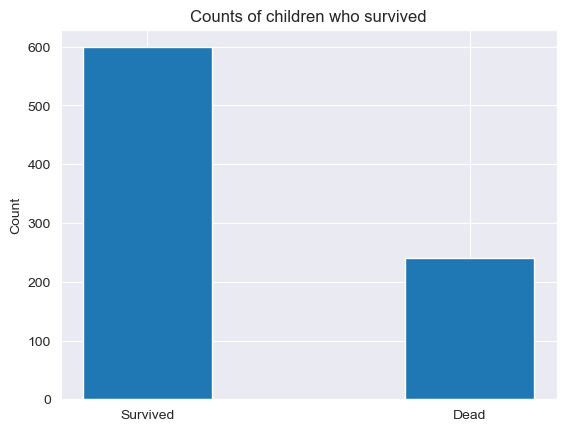

In [12]:
#count number of children who survived
count_survived = len(data.end_status[data['end_status'] == 0])
count_dead = len(data.end_status[data['end_status'] == 1])
print(f"Number of children who survived: {count_survived} ({count_survived*100/840:.2f}%)")
print(f"Number of children that died: {count_dead} ({count_dead*100/840:.2f}%)")

plt.bar(['Survived', 'Dead'], [count_survived, count_dead], width=0.4)
plt.title('Counts of children who survived')
plt.ylabel('Count')
plt.show()

### 2.3. Does gender play a role?

Number of boys: 403 (47.98%)
Number of girls: 437 (52.02%)


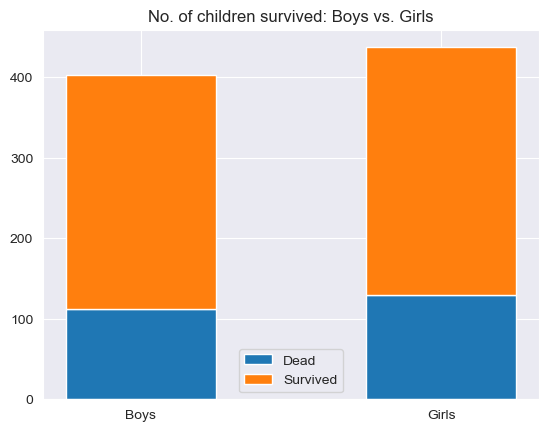

In [12]:
#count number of boys and girls
count_boys = len(data.sex[data['sex'] == 0])
count_girls = len(data.sex[data['sex'] == 1])

print(f"Number of boys: {count_boys} ({count_boys*100/840:.2f}%)")
print(f"Number of girls: {count_girls} ({count_girls*100/840:.2f}%)")

#count boys and girls who did not survive
count_dead_boys = len(data.sex[(data['sex'] == 0) & (data['end_status'] == 1)])
count_dead_girls = len(data.sex[(data['sex'] == 1) & (data['end_status'] == 1)])

x_labels = ("Boys", "Girls")

weight_counts = {
    "Dead": [count_dead_boys, count_dead_girls],
    "Survived": [count_boys - count_dead_boys, count_girls - count_dead_girls],
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

#plot a stacked bar chart
for boolean, weight_count in weight_counts.items():
    p = ax.bar(x_labels, weight_count, width=0.5, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("No. of children survived: Boys vs. Girls")
ax.legend()

plt.show()

We observe that the number of girls in the dataset is slightly higher than the number of boys. The death toll is also slightly higher among girls. We can infer that there is no significant relation between the gender and mortality.

### 2.4. Does age of vaccination influence mortality?

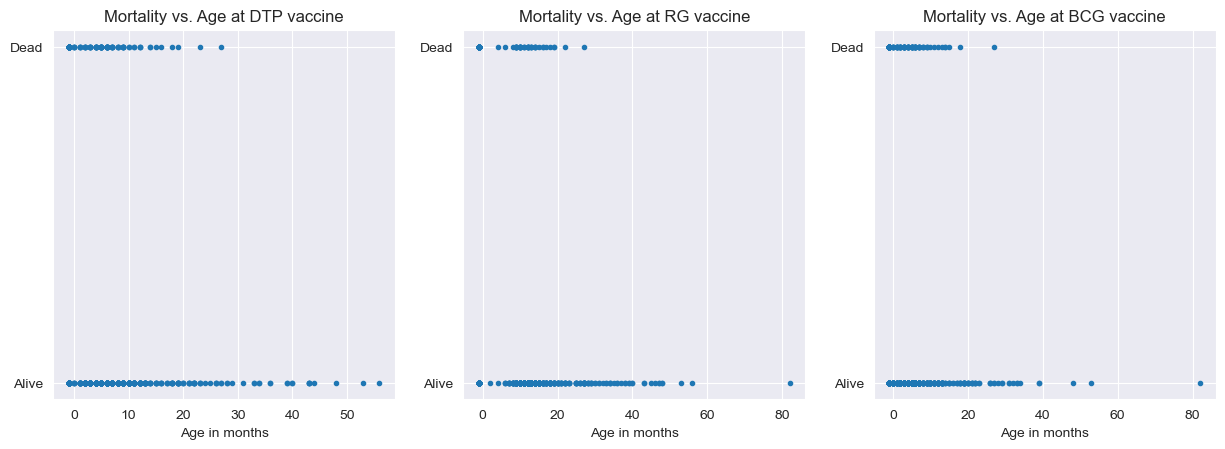

In [13]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)

ax[0].scatter(data['dtp_age'], data['end_status'], marker='.')
ax[0].set_title("Mortality vs. Age at DTP vaccine")
ax[0].set_yticks([0, 1], labels=['Alive', 'Dead'])
ax[0].set_xlabel("Age in months")

ax[1].scatter(data['rg_age'], data['end_status'], marker='.')
ax[1].set_title("Mortality vs. Age at RG vaccine")
ax[1].set_yticks([0, 1], labels=['Alive', 'Dead'])
ax[1].set_xlabel("Age in months")

ax[2].scatter(data['bcg_age'], data['end_status'], marker='.')
ax[2].set_title("Mortality vs. Age at BCG vaccine")
ax[2].set_yticks([0, 1], labels=['Alive', 'Dead'])
ax[2].set_xlabel("Age in months")

plt.show()

There does not appear to be any clear trend in the survival rate of a child based on the age at which the vaccine was administered. It can be noted, however, that some of the children who survived were vaccinated at an older age. This can probably attributed to the fact that children who died at a younger age might not have had the opportunity to be vaccinated.

### 2.5. What were the main causes of death?

In [14]:
dead = data[data['end_status'] == 1]
dead.head()

,region,sex,dtp_age,rg_age,bcg_age,mother_age,end_age,end_status,dispensary,death_cause,dtp_6months,bcg_6months,rg_6months,birth_season,diarrhea,fever,cough
3,0,0,-1.0,-1.0,-1.0,17,0,1,0,1.0,0,0,0,1,0,0,0
4,0,1,-1.0,-1.0,-1.0,30,1,1,0,9.0,0,0,0,1,0,0,0
7,0,1,-1.0,-1.0,-1.0,22,20,1,0,9.0,0,0,0,0,0,0,0
11,0,0,-1.0,-1.0,-1.0,26,6,1,0,9.0,0,0,0,0,0,0,0
13,0,1,-1.0,-1.0,-1.0,35,9,1,0,2.0,0,0,0,0,0,0,0


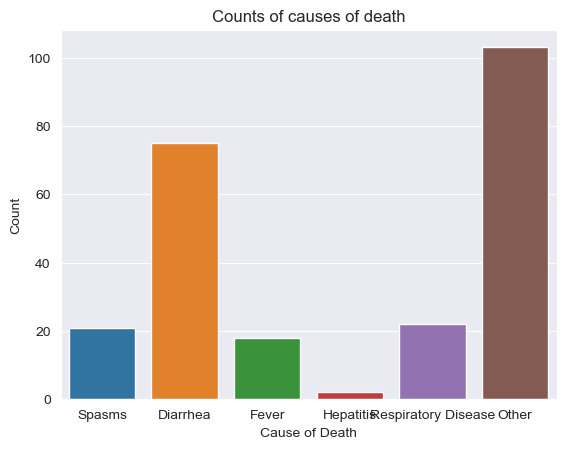

In [15]:
#plotting causes of death
death_count_plot = sns.countplot(dead, x=dead['death_cause'])

labels = ['Spasms', 'Diarrhea', 'Fever', 'Hepatitis', 'Respiratory Disease', 'Other']
death_count_plot.set_xticks([i for i in range(6)], labels)
death_count_plot.set_xlabel("Cause of Death")
death_count_plot.set_ylabel("Count")
death_count_plot.set_title("Counts of causes of death")

plt.show()

### 2.6. Correlation Analysis

<Axes: >

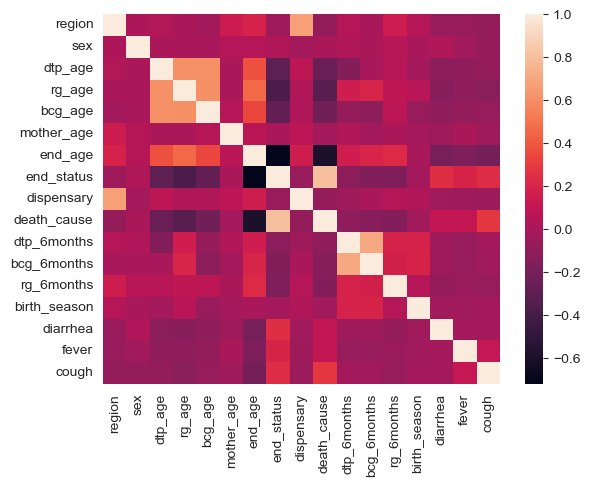

In [16]:
corr_matrix = data.corr()

sns.heatmap(corr_matrix)

The following columns have very low correlation with the output variable end_status, and will therefore be discarded:
* *region*
* *sex*
* *mother_age*
* *dispensary*
* *birth_season*

In [17]:
data.drop(columns=['region', 'sex', 'mother_age', 'dispensary', 'birth_season'], inplace=True)

## 3. Data Preprocessing
### 3.1. Feature Engineering
The *diarrhea*, *fever*, and *cough* columns show slight positive correlation with *end_status*. We can combine these columns into a single feature called *sickness*. This will help with dimensionality reduction, and increase correlation.

In [18]:
sickness = np.empty(len(data), dtype='int32')
for i in range(len(data)):
    if data.diarrhea[i] or data.fever[i] or data.cough[i]:
        sickness[i] = 1
    else:
        sickness[i] = 0

We can repeat the same thing for *dtp_6months*, *rg_6months* and *bcg_6months*.

In [19]:
vaccine_6months = np.zeros(len(data), dtype='int32')
for i in range(len(data)):
    if data.dtp_6months[i] or data.rg_6months[i] or data.bcg_6months[i]:
        vaccine_6months[i] = 1

In [20]:
data.drop(columns=['diarrhea', 'fever', 'cough', 'dtp_6months', 'rg_6months', 'bcg_6months'], inplace=True)
data['sickness'] = sickness
data['vaccine_6months'] = vaccine_6months

We can obtain higher correlation values if we encode *dtp_age*, *rg_age*, and *bcg_age* as binary variables rather than numeric variables. We replace all -1 values with 0 and with 1 otherwise.

In [21]:
data.dtp_age = np.where(data.dtp_age == -1, 0, 1)
data.rg_age = np.where(data.rg_age == -1, 0, 1)
data.bcg_age = np.where(data.bcg_age == -1, 0, 1)

<Axes: >

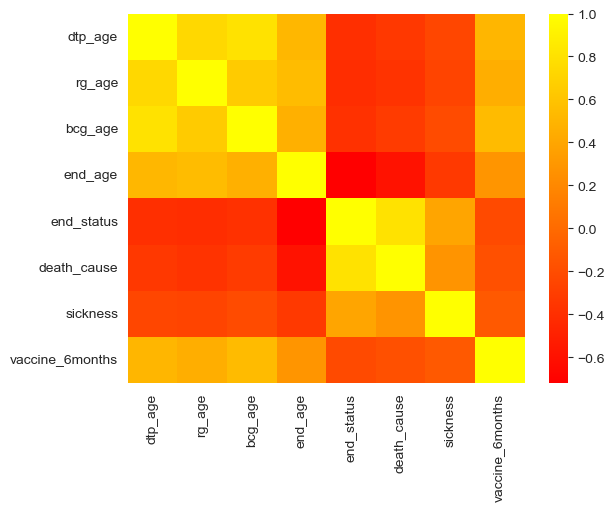

In [22]:
final_corr = data.corr()

sns.heatmap(final_corr, cmap='autumn')

### 3.2. Train test split

In [23]:
X = data.drop(columns=['end_status'])
y = data['end_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

## 4. Model Building
### 4.1. Logistic Regression

In [24]:
LRModel = LogisticRegression()
LRModel.fit(X_train, y_train)

LogisticRegression()

### 4.2. Decision Tree Classifier

In [25]:
DTModel = DecisionTreeClassifier()
DTModel.fit(X_train, y_train)

DecisionTreeClassifier()

## 5. Model Evaluation
### 5.1. Logistic Regression

In [33]:
#calculating accuracy
lr_accuracy = LRModel.score(X_test, y_test)
print(f"Accuracy of model is: {lr_accuracy}")

#creating confusion matrix
confusion_matrix(y_test, LRModel.predict(X_test))

Accuracy of model is: 0.9880952380952381


array([[120,   0],
       [  2,  46]])

### 5.2. Decision Tree

In [34]:
#calculating accuracy
dt_accuracy = DTModel.score(X_test, y_test)
print(f"Accuracy of model is: {dt_accuracy}")

#creating confusion matrix
confusion_matrix(y_test, DTModel.predict(X_test))

Accuracy of model is: 1.0


array([[120,   0],
       [  0,  48]])